# Kriging Compute Task

This notebook demonstrates how to run kriging compute tasks using the `evo-compute` package.

Kriging is a geostatistical interpolation technique that estimates values at unsampled locations
using weighted averages of nearby known values, based on a variogram model of spatial correlation.

## Authentication

First, authenticate using the `ServiceManagerWidget`:

In [ ]:
from evo.notebooks import ServiceManagerWidget

manager = await ServiceManagerWidget.with_auth_code(
    client_id="core-compute-tasks-notebooks",  # Replace with your client ID
    base_uri="https://qa-ims.bentley.com",
    discovery_url="https://int-discover.test.api.seequent.com",
    cache_location="./notebook-data",
).login()

## Setup for Local Development

> **Note:** If the imports below fail, you may need to add the local source packages to your Python path. Run the cell below first.

In [ ]:
# Setup for local development source - run this cell FIRST if you get import errors
# You may need to restart your kernel after running this cell for the first time
import sys

# Remove any cached evo.compute modules to force reimport from local source
mods_to_remove = [key for key in list(sys.modules.keys()) if key.startswith('evo.compute')]
for mod in mods_to_remove:
    del sys.modules[mod]

local_paths = [
    r"C:\Source\evo-python-sdk\packages\evo-compute\src",
    r"C:\Source\evo-python-sdk\packages\evo-blockmodels\src",
    r"C:\Source\evo-python-sdk\packages\evo-objects\src",
    r"C:\Source\evo-python-sdk\packages\evo-sdk-common\src",
]
for path in local_paths:
    if path not in sys.path:
        sys.path.insert(0, path)

print("Local source paths configured - restart kernel if you still see import errors")

## Example 1: Run Kriging on Existing Objects

This example shows how to run kriging using existing geoscience objects (source pointset, target grid, and variogram).

### Load the Source PointSet, Target Grid, and Variogram

In [ ]:
from evo.objects.typed import object_from_uuid, object_from_path

# Load objects by UUID (replace with your actual UUIDs)
source_pointset = await object_from_uuid(manager, "9100d7dc-44e9-4e61-b427-159635dea22f")
# Alternative: load by path
# source_pointset = await object_from_path(manager, "path/to/pointset.json")

target_grid = await object_from_uuid(manager, "df9c3705-c82e-4f57-af94-b3346b5d58cf")
# Alternative: load by path
# target_grid = await object_from_path(manager, "path/to/grid.json")

variogram = await object_from_uuid(manager, "72cd9b83-90f4-4cb0-9691-95728e3f9cbb")
# Alternative: load by path
# variogram = await object_from_path(manager, "path/to/variogram.json")

In [ ]:
# Pretty-print the source pointset (includes Portal/Viewer links)
source_pointset

In [ ]:
# View the source pointset attributes
source_pointset.attributes

In [ ]:
# Pretty-print the target grid
target_grid

In [ ]:
# Pretty-print the variogram
variogram

### Run Kriging Task

In [ ]:
from evo.compute.tasks import (
    run_kriging,
    KrigingParameters,
    SearchNeighbourhood,
)
from evo.objects.typed import Ellipsoid, EllipsoidRanges
from evo.objects.typed.ellipsoid import Rotation as EllipsoidRotation
from evo.notebooks import FeedbackWidget

# Get ellipsoid from the first variogram structure
var_ell = variogram.get_ellipsoid()

# Create search ellipsoid by scaling the variogram ellipsoid by 2x
search_ellipsoid = var_ell.scaled(2.0)

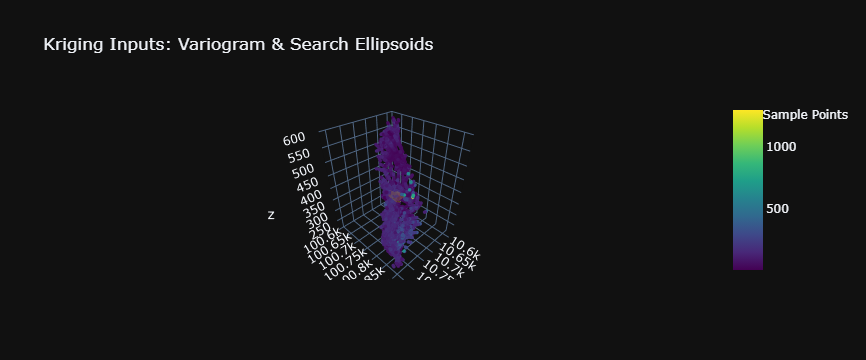

In [13]:
# Visualize variogram and search ellipsoids with pointset data
import plotly.graph_objects as go

# Get pointset data for center calculation and scatter plot
pts = await source_pointset.to_dataframe()
center = (pts["x"].mean(), pts["y"].mean(), pts["z"].mean())

# Generate mesh surface points for visualization
vx, vy, vz = var_ell.surface_points(center=center)
sx, sy, sz = search_ellipsoid.surface_points(center=center)

# Build visualization
var_mesh = go.Mesh3d(x=vx, y=vy, z=vz, alphahull=0, opacity=0.3, color="blue", name="Variogram Ellipsoid")
search_mesh = go.Mesh3d(x=sx, y=sy, z=sz, alphahull=0, opacity=0.2, color="gold", name="Search Ellipsoid (2x)")
scatter = go.Scatter3d(
    x=pts["x"], y=pts["y"], z=pts["z"],
    mode="markers",
    marker=dict(size=2, color=pts["Ag_ppm Values"], colorscale="Viridis", showscale=True),
    name="Sample Points"
)

fig = go.Figure(data=[var_mesh, search_mesh, scatter])
fig.update_layout(
    title="Kriging Inputs: Variogram & Search Ellipsoids",
    scene=dict(aspectmode="data"),
    showlegend=True
)
fig.show()


In [22]:
# Create kriging parameters
# Note: method defaults to ordinary kriging, so we don't need to specify it
kriging_params = KrigingParameters(
    source=source_pointset.attributes["Ag_ppm Values"],
    target=target_grid.attributes["kriged_grade 5"],
    variogram=variogram,
    search=SearchNeighbourhood(
        ellipsoid=search_ellipsoid,
        max_samples=20,
    ),
)

# Run the kriging task with progress feedback
print("Submitting kriging task...")
fb = FeedbackWidget("Kriging task")
job_result = await run_kriging(manager, kriging_params, fb=fb)

# Display the kriging result (pretty-printed)
job_result

Submitting kriging task...


Target:,Block Model - LMS1 Kr - point kriging
Schema:,pointset
Attribute:,kriged_grade 5


In [24]:
# Get the data directly as a DataFrame (simplest approach)
df = await job_result.to_dataframe()
print(f"Retrieved {len(df)} rows")
df.head()

Retrieved 1846 rows


,x,y,z,"Kr, Ag_LMS1 NS20: 5x5x5","Kr, Ag_LMS1 NS20: 5x5x5: NS","Kr, Ag_LMS1 NS20: 5x5x5: MinD","Kr, Ag_LMS1 NS20: 5x5x5: AvgD","Kr, Ag_LMS1 NS20: 5x5x5: KM","Kr, Ag_LMS1 NS20: 5x5x5: KV","Kr, Ag_LMS1 NS20: 5x5x5: SoR","Kr, Ag_LMS1 NS20: 5x5x5: KE","Kr, Ag_LMS1 NS20: 5x5x5: Sum","Kr, Ag_LMS1 NS20: 5x5x5: SumN","Kr, Ag_LMS1 NS20: 5x5x5: ND",kriged_grade,kriged_grade 2,kriged_grade 3,kriged_grade 4,kriged_grade ag,kriged_grade 5
0,10816.763,100825.177,210.274,119.731708,20.0,8.897571,17.825285,120.191749,1958.56897,0.909802,0.434233,1.0,-0.002070,0.0,115.387454,115.387454,115.387454,115.387454,119.731662,115.250872
1,10806.763,100815.177,220.274,76.814841,20.0,8.183241,13.714486,96.748578,2061.34253,0.858110,0.404545,1.0,-0.014257,0.0,71.129915,71.129915,71.129915,71.129915,76.814845,67.107411
2,10816.763,100815.177,220.274,98.728318,20.0,9.628093,14.343268,90.393515,1945.59033,0.902137,0.437982,1.0,0.000000,0.0,94.841677,94.841677,94.841677,94.841677,98.728319,104.589466
3,10816.763,100825.177,220.274,87.073170,20.0,6.555643,9.548813,93.195482,1529.41052,0.966866,0.558203,1.0,-0.042352,0.0,87.436372,87.436372,87.436372,87.436372,87.073158,90.891962
4,10816.763,100835.177,220.274,90.628333,20.0,3.348951,11.142876,125.288306,1057.79016,0.986297,0.694439,1.0,-0.013105,0.0,87.646563,87.646563,87.646563,87.646563,90.628303,91.661266


In [17]:
# Or load the target object for more control
target_grid = await job_result.get_target_object()

# Pretty-print the updated target grid
target_grid

In [ ]:
# Or get the data as a DataFrame directly
df = await job_result.to_dataframe()
print(f"Retrieved {len(df)} cells")
df.head()

## Example 2: Create Objects and Run Kriging

This example shows how to create the input objects from scratch and then run kriging.

### Create the Source PointSet

In [ ]:
import uuid
import numpy as np
import pandas as pd
from evo.objects.typed import EpsgCode, PointSet, PointSetData

# Generate sample point data
n_points = 100
np.random.seed(42)

# Create points in a 1000x1000x100 domain
x = np.random.uniform(0, 1000, n_points)
y = np.random.uniform(0, 1000, n_points)
z = np.random.uniform(0, 100, n_points)

# Create an elevation attribute (z + some noise)
elevation = z + np.random.normal(0, 5, n_points)

# Create pointset using PointSetData
pointset_data = PointSetData(
    name=f"Sample Source Points - {uuid.uuid4()}",
    coordinate_reference_system=EpsgCode(32632),
    locations=pd.DataFrame({"x": x, "y": y, "z": z, "elevation": elevation}),
)

# Create the pointset object
source_pointset_created = await PointSet.create(manager, pointset_data)

print(f"Created source pointset: {source_pointset_created.name}")

In [ ]:
# Pretty-print the created pointset (includes Portal/Viewer links)
source_pointset_created

In [ ]:
# View the created pointset attributes
source_pointset_created.attributes

### Create a Variogram

Create a variogram using the typed `Variogram` class.

In [ ]:
from evo.objects.typed import Variogram, VariogramData, SphericalStructure, Anisotropy
from evo.objects.typed import EllipsoidRanges

# Define a spherical variogram model using typed classes
variogram_data = VariogramData(
    name=f"Sample Variogram - {uuid.uuid4()}",
    sill=1.0,
    nugget=0.1,
    is_rotation_fixed=True,
    modelling_space="data",  # Required for kriging
    data_variance=1.0,       # Should match sill for non-normalized data
    structures=[
        SphericalStructure(
            contribution=0.9,
            anisotropy=Anisotropy(
                ellipsoid_ranges=EllipsoidRanges(major=200.0, semi_major=200.0, minor=100.0),
            ),
        )
    ],
    attribute="elevation",
    domain="all",
)

variogram_created = await Variogram.create(manager, variogram_data)

print(f"Created variogram: {variogram_created.name}")

In [ ]:
# Pretty-print the created variogram
variogram_created

### Visualize the Variogram

Use the variogram visualization tool to inspect the directional variogram curves and anisotropy ellipsoids.
This helps verify that the variogram parameters are correct before running kriging.

In [ ]:
# Visualize variogram and search ellipsoids with pointset data
import plotly.graph_objects as go

# Get pointset data for center calculation and scatter plot
pts = await source_pointset_created.to_dataframe()
center = (pts["x"].mean(), pts["y"].mean(), pts["z"].mean())

# Create ellipsoid from variogram (first structure)
var_ell = variogram_created.get_ellipsoid()
vx, vy, vz = var_ell.surface_points(center=center)

# Create search ellipsoid scaled by 2x
search_ell = var_ell.scaled(2.0)
sx, sy, sz = search_ell.surface_points(center=center)

# Build visualization
var_mesh = go.Mesh3d(x=vx, y=vy, z=vz, alphahull=0, opacity=0.3, color="blue", name="Variogram Ellipsoid")
search_mesh = go.Mesh3d(x=sx, y=sy, z=sz, alphahull=0, opacity=0.2, color="gold", name="Search Ellipsoid (2x)")
scatter = go.Scatter3d(
    x=pts["x"], y=pts["y"], z=pts["z"],
    mode="markers",
    marker=dict(size=2, color=pts["elevation"], colorscale="Viridis", showscale=True),
    name="Sample Points"
)

fig = go.Figure(data=[var_mesh, search_mesh, scatter])
fig.update_layout(
    title="Kriging Inputs: Variogram & Search Ellipsoids",
    scene=dict(aspectmode="data"),
    showlegend=True
)
fig.show()


### Create the Target Grid

In [ ]:
from evo.objects.typed import Point3, RegularMasked3DGrid, RegularMasked3DGridData, Size3d, Size3i
from evo.objects.typed import Rotation as GridRotation

# Define grid dimensions
nx, ny, nz = 20, 20, 10  # Number of cells in each direction
cell_size = 50.0  # Size of each cell

# Create a mask for the grid (all cells active in this example)
total_cells = nx * ny * nz
mask = np.ones(total_cells, dtype=bool)

# Optionally, mask out some cells to create a more interesting shape
for zi in range(nz // 2):
    for yi in range(ny // 2):
        for xi in range(nx // 2):
            idx = xi + yi * nx + zi * nx * ny
            mask[idx] = False

# Create masked grid using RegularMasked3DGridData
grid_data = RegularMasked3DGridData(
    name=f"Target Masked Grid - {uuid.uuid4()}",
    coordinate_reference_system=EpsgCode(32632),
    origin=Point3(0, 0, 0),
    size=Size3i(nx, ny, nz),
    cell_size=Size3d(cell_size, cell_size, cell_size),
    rotation=GridRotation(0, 0, 0),
    mask=mask,
    cell_data=None,  # No attributes yet, kriging will add them
)

# Create the grid object
target_grid_created = await RegularMasked3DGrid.create(manager, grid_data)

print(f"Created target grid: {target_grid_created.name}")
print(f"  Total cells: {nx} x {ny} x {nz} = {total_cells}")
print(f"  Active cells: {int(mask.sum())}")
print(f"  Bounding box: {target_grid_created.bounding_box}")

In [ ]:
# Pretty-print the created grid (includes Portal/Viewer links)
target_grid_created

### Run Kriging on Created Objects

In [ ]:
from evo.compute.tasks import (
    run_kriging,
    KrigingParameters,
    Target,
    SearchNeighbourhood,
)
from evo.objects.typed import Ellipsoid, EllipsoidRanges
from evo.objects.typed.ellipsoid import Rotation as EllipsoidRotation
from evo.notebooks import FeedbackWidget

# Create kriging parameters using typed Attribute access
# source_pointset_created.locations.attributes["elevation"] gives us an Attribute object
kriging_params = KrigingParameters(
    source=source_pointset_created.locations.attributes["elevation"],
    target=Target.new_attribute(target_grid_created, attribute_name="kriged_elevation2"),
    variogram=variogram_created,
    search=SearchNeighbourhood(
        ellipsoid=Ellipsoid(
            ranges=EllipsoidRanges(major=134.0, semi_major=90.0, minor=40.0),
            rotation=EllipsoidRotation(dip_azimuth=100.0, dip=65.0, pitch=75.0),
        ),
        max_samples=20,
    ),
)

# Run the kriging task
print("Submitting kriging task...")
fb = FeedbackWidget("Kriging task")
job_result = await run_kriging(manager, kriging_params, fb=fb)

print("Task completed!")

In [ ]:
# Display the kriging result (pretty-printed)
job_result

In [ ]:
# Get the data directly as a DataFrame
df = await job_result.to_dataframe()
print(f"Retrieved {len(df)} cells with kriged values")
df.head()
